In [4]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from qiskit.opflow import CircuitStateFn, CircuitOp
from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Sampler, Options
from qiskit.quantum_info import SparsePauliOp

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-education/uni-antioquia-2/quantum-alg',
)
backend = "ibmq_qasm_simulator"  

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()
import numpy as np

# Implementación del circuito

Se implementa un circuito para establecer el entrelazamiento entre dos cubits

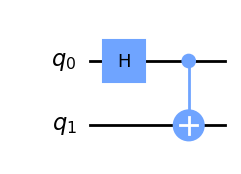

In [5]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.draw(output='mpl')

Se redefine el circuito como una variable para su posterior uso en el calculo del valor estimado de manera manual

In [6]:
psi = CircuitStateFn(qc)

Posteriormente se estable el operador sobre el que interactua el circuito

In [7]:
operator_circuit = QuantumCircuit(2)
operator_circuit.ry(np.pi/2, 0)
op = CircuitOp(operator_circuit)

Se realiza la operación de estimador de manera manual
operación realizada según el siguiente foro: [https://quantumcomputing.stackexchange.com/questions/12080/evaluating-expectation-values-of-operators-in-qiskit](https://quantumcomputing.stackexchange.com/questions/12080/evaluating-expectation-values-of-operators-in-qiskit)

In [8]:
print('Math:', psi.adjoint().compose(op).compose(psi).eval().real)

Math: 0.7071067811865475


Se replica el circuito de entrelazamiento para un cambio de theta que permita establecer la medida en un eje distinto

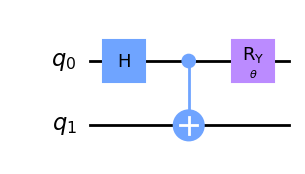

In [9]:
theta = Parameter("$\\theta$")

circuito_base = QuantumCircuit(2)
circuito_base.h(0)
circuito_base.cx(0, 1)
circuito_base.ry(theta, 0)
circuito_base.draw(output="mpl")

Se genera un vector de angulos con los que se prueba la inigualdad.

In [10]:
theta_vec = np.linspace(0, 2 * np.pi, 18)
fases_desglosadas = [[fase] for fase in theta_vec]

Se establecen los operadores Pauli para los diferentes ejes de medición

In [11]:
ZZ = SparsePauliOp.from_list([("ZZ", 1)])
ZX = SparsePauliOp.from_list([("ZX", 1)])
XZ = SparsePauliOp.from_list([("XZ", 1)])
XX = SparsePauliOp.from_list([("XX", 1)])

Se instancia la medición para el backend establecido previamente y se usa la función Estimator para establecer la operación de estimación de los resultados del circuito

In [12]:
ops = [ZZ, ZX, XZ, XX]
chsh_Estimacion = []

with Session(service=service, backend=backend):
    estimator = Estimator()
    for op in ops:
        job = estimator.run(
            circuits=[circuito_base] * len(fases_desglosadas),
            observables=[op] * len(fases_desglosadas),
            parameter_values=fases_desglosadas,
        )
        est_result = job.result()
        chsh_Estimacion.append(est_result)

Se realiza el calculo de la operación de desigualdad a partir de los valores obtenidos para los diferentes desfases

In [13]:
chsh_estimado_1 = (
    chsh_Estimacion[0].values
    - chsh_Estimacion[1].values
    + chsh_Estimacion[2].values
    + chsh_Estimacion[3].values
)

chsh_estimado_2 = (
    chsh_Estimacion[0].values
    + chsh_Estimacion[1].values
    - chsh_Estimacion[2].values
    + chsh_Estimacion[3].values
)

In [14]:
chsh_estimado_1

array([ 2.0185,  1.121 ,  0.117 , -0.905 , -1.796 , -2.441 , -2.7965,
       -2.756 , -2.321 , -1.593 , -0.6515,  0.395 ,  1.392 ,  2.183 ,
        2.7145,  2.793 ,  2.5715,  1.9695])

In [15]:
chsh_estimado_2

array([ 1.9815,  2.626 ,  2.836 ,  2.685 ,  2.189 ,  1.426 ,  0.4155,
       -0.652 , -1.597 , -2.341 , -2.7585, -2.788 , -2.46  , -1.793 ,
       -0.8805,  0.118 ,  1.1535,  2.0305])

Se realiza un grafico para la función en terminos de los diferentes angulos de fase y los valores del calculo para la desigualdad

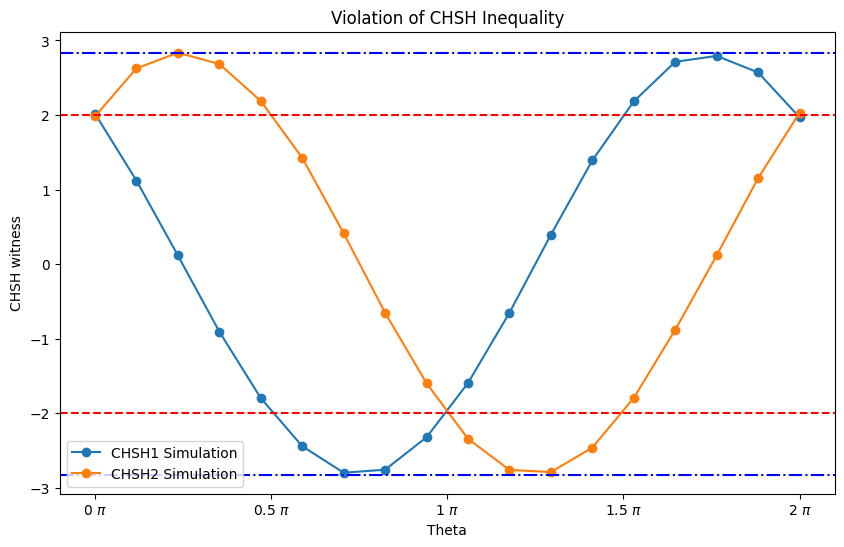

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

fig, ax = plt.subplots(figsize=(10, 6))
# results from a simulator
ax.plot(theta_vec / np.pi, chsh_estimado_1, "o-", label="CHSH1 Simulation")
ax.plot(theta_vec / np.pi, chsh_estimado_2, "o-", label="CHSH2 Simulation")
# classical bound +-2
ax.axhline(y=2, color="r", linestyle="--")
ax.axhline(y=-2, color="r", linestyle="--")
# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="b", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="b", linestyle="-.")
# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
# set title, labels, and legend
plt.title("Violation of CHSH Inequality")
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()

Se replica el proceso anterior para un computador real

In [17]:
from qiskit_ibm_provider import IBMProvider

In [18]:
provider = IBMProvider(instance="ibm-q-education/uni-antioquia-2/quantum-alg")
provider

<IBMProvider>

In [19]:
from qiskit_ibm_provider import least_busy

small_devices = service.backends(min_num_qubits=2, simulator=False, operational=True)
backend = least_busy(small_devices)
print(backend)

<IBMBackend('ibmq_belem')>


In [20]:
ops = [ZZ, ZX, XZ, XX]
chsh_Estimacion = []

with Session(service=service, backend=backend):
    estimator = Estimator()
    for op in ops:
        job = estimator.run(
            circuits=[circuito_base] * len(fases_desglosadas),
            observables=[op] * len(fases_desglosadas),
            parameter_values=fases_desglosadas,
        )
        est_result = job.result()
        chsh_Estimacion.append(est_result)

In [21]:
chsh_estimado_1 = (
    chsh_Estimacion[0].values
    - chsh_Estimacion[1].values
    + chsh_Estimacion[2].values
    + chsh_Estimacion[3].values
)

chsh_estimado_2 = (
    chsh_Estimacion[0].values
    + chsh_Estimacion[1].values
    - chsh_Estimacion[2].values
    + chsh_Estimacion[3].values
)

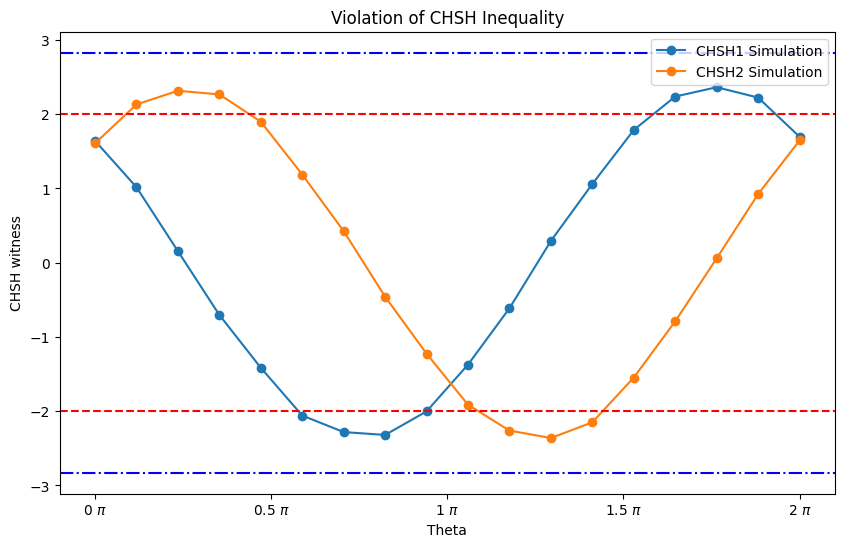

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
# results from a simulator
ax.plot(theta_vec / np.pi, chsh_estimado_1, "o-", label="CHSH1 Simulation")
ax.plot(theta_vec / np.pi, chsh_estimado_2, "o-", label="CHSH2 Simulation")
# classical bound +-2
ax.axhline(y=2, color="r", linestyle="--")
ax.axhline(y=-2, color="r", linestyle="--")
# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="b", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="b", linestyle="-.")
# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
# set title, labels, and legend
plt.title("Violation of CHSH Inequality")
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()

In [23]:
chsh_estimado_1

array([ 1.6425,  1.0175,  0.156 , -0.703 , -1.4145, -2.058 , -2.281 ,
       -2.3195, -2.0025, -1.3725, -0.6135,  0.293 ,  1.0605,  1.7875,
        2.2385,  2.3635,  2.2245,  1.6965])

In [24]:
chsh_estimado_2

array([ 1.6075,  2.1315,  2.316 ,  2.267 ,  1.8995,  1.188 ,  0.426 ,
       -0.4575, -1.2245, -1.9125, -2.2605, -2.361 , -2.1495, -1.5465,
       -0.7895,  0.0585,  0.9235,  1.6465])